(4846, 50, 5)
(539, 50, 5)


C:\Users\siwoo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
137/137 [==============================] - 70s 44ms/step - loss: 0.0263 - val_loss: 2.7569e-04
Epoch 2/50
137/137 [==============================] - 4s 27ms/step - loss: 6.3249e-04 - val_loss: 1.5580e-04
Epoch 3/50
137/137 [==============================] - 4s 27ms/step - loss: 5.1516e-04 - val_loss: 1.3865e-04
Epoch 4/50
137/137 [==============================] - 4s 27ms/step - loss: 4.8100e-04 - val_loss: 1.6464e-04
Epoch 5/50
137/137 [==============================] - 4s 28ms/step - loss: 4.0655e-04 - val_loss: 1.8820e-04
Epoch 6/50
137/137 [==============================] - 4s 28ms/step - loss: 4.2340e-04 - val_loss: 1.3291e-04
Epoch 7/50
137/137 [==============================] - 4s 27ms/step - loss: 3.9643e-04 - val_loss: 1.7506e-04
Epoch 8/50
137/137 [==============================] - 4s 27ms/step - loss: 3.3131e-04 - val_loss: 1.5878e-04
Epoch 9/50
137/137 [==============================] - 4s 28ms/step - loss: 3.3715e-04 - val_loss: 2.4364e-04
Epoch 10/50
137/137 [=

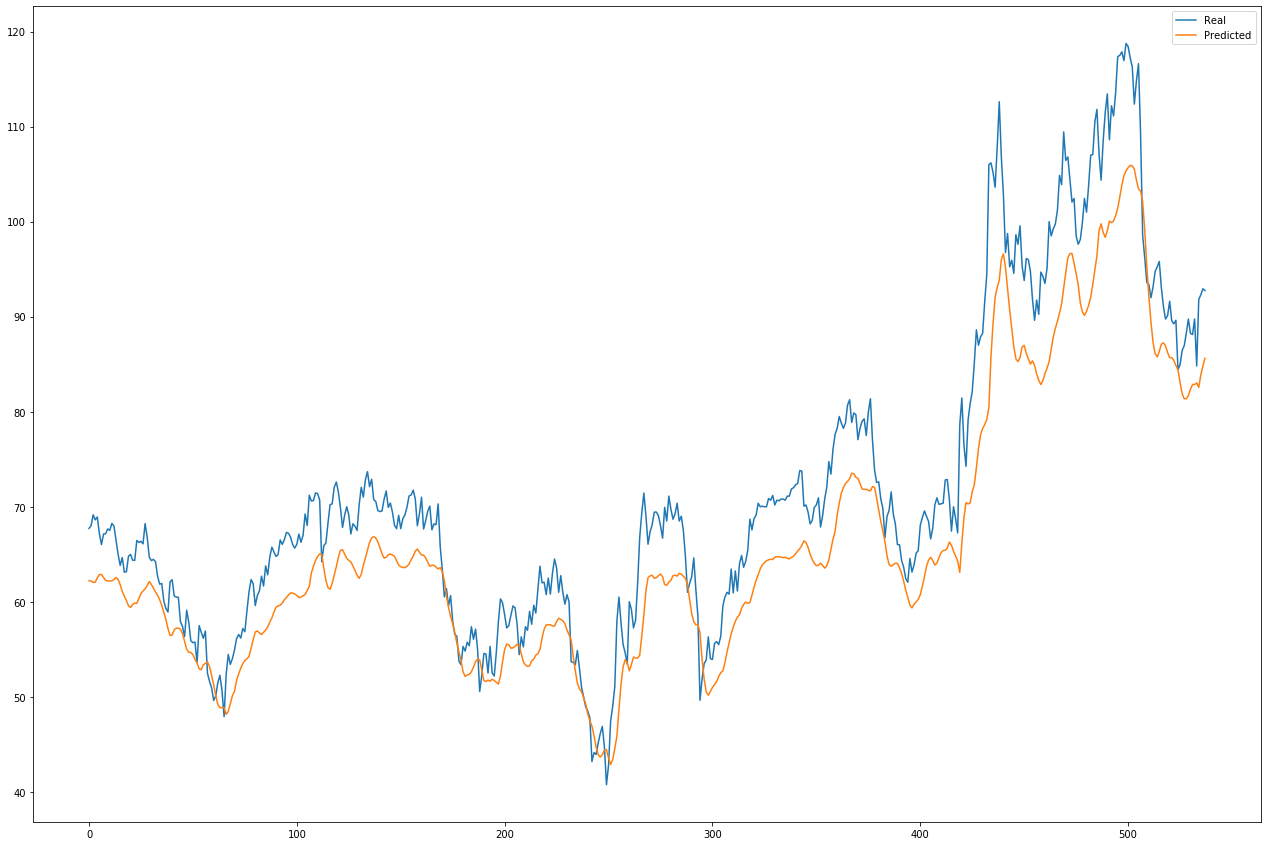

In [2]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow
tensorflow.random.set_seed(4)
from util import csv_to_dataset, history_points


# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')
